<a href="https://colab.research.google.com/github/Shkum/IT_STEP/blob/ML/HomeWork_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [1444]:
import torch
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

Дані медичне страхування

In [1445]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/insurance.csv')

df['sex'] = df['sex'].map({'male': 0, 'female':1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes':1})

df = df.drop(columns=['region'])

data = df[['age', 'bmi', 'expenses']]
df[['age', 'bmi', 'expenses']] = (data - data.min()) / (data.max() - data.min())

In [1446]:
df.head()

,age,sex,bmi,children,smoker,expenses
0,0.021739,1,0.320755,0,1,0.251611
1,0.000000,0,0.479784,1,0,0.009636
2,0.217391,0,0.458221,3,0,0.053115
3,0.326087,0,0.180593,0,0,0.333010
4,0.304348,0,0.347709,0,0,0.043816


Потрібно на основі інформації людини спрогнозувати розмір її страховки `expenses`

# Завдання 1
Створіть клас Dataset

In [1447]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.Tensor(X.values).to(device)
      self.y = torch.Tensor(y.values).to(device)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['expenses'])
y = df['expenses']

dataset = MyDataset(X, y)

In [1448]:
X.head(2)

,age,sex,bmi,children,smoker
0,0.021739,1,0.320755,0,1
1,0.000000,0,0.479784,1,0


# Завдання 2
Створіть DataLoader. Перевірте розміри даних в першому пакеті. Розмір пакетів оберіть самостійно

In [1449]:
from torch.utils.data import DataLoader

batch_size = 256
dataloader = DataLoader(dataset,  # датасет з даними
                        batch_size=batch_size,  # кількість даних в одному пакеті
                        shuffle=True,  # чи треба перемішувати дані
                        generator=torch.Generator(device=device)) # підключення до процесора)

In [1450]:
X_batch, y_batch = next(iter(dataloader))

In [1451]:
X_batch.shape

torch.Size([256, 5])

In [1452]:
y_batch.shape

torch.Size([256, 1])

# Завдання 3
Створіть нейромережу:
* Кількість шарів оберіть між 1-5
* Виберіть різні функції активації: Relu, LeakyRelu, Swish
* Кілкість нейронів у прихованих шарах повинна **не зростати**

In [1453]:
from torch import nn

model = nn.Sequential(
    nn.Linear(5, 100),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(50, 20),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.4),
    nn.Linear(20, 3),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.4),
    nn.Linear(3, 1)
)


print(model)

Sequential(
  (0): Linear(in_features=5, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=100, out_features=50, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=50, out_features=20, bias=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Dropout(p=0.4, inplace=False)
  (9): Linear(in_features=20, out_features=3, bias=True)
  (10): LeakyReLU(negative_slope=0.2)
  (11): Dropout(p=0.4, inplace=False)
  (12): Linear(in_features=3, out_features=1, bias=True)
)


# Завдання 4
Визначте функцію втрат та оптимізатор

In [1454]:
# Функція втрат середньоквадратичної помилки (MSE) для регресії
loss_fn = nn.MSELoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0055)

# Завдання 5
Натренуйте нейромережу. візміть невелику кількість епох

In [1455]:

%%time
import numpy as np

num_epochs = 100
losses = []

for epoch in range(num_epochs):
    losses_ = []
    for X_batch, y_batch in dataloader:
        # пряме пошерення
        prediction = model(X_batch)
        loss = loss_fn(prediction, y_batch)
        losses_.append(loss.item())

        # Зворотнє поширення
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    losses.append(np.mean(losses_))

CPU times: user 2.6 s, sys: 11.5 ms, total: 2.61 s
Wall time: 2.62 s


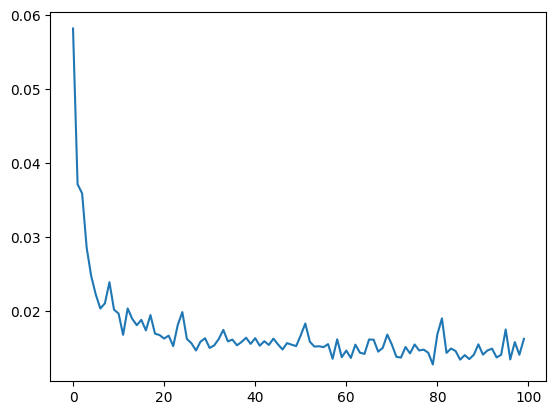

In [1456]:
import matplotlib.pyplot as plt

plt.plot(losses)
#plt.ylim(0, 0.2*1e8)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [1457]:
torch.save(model, 'model.pt')

In [1458]:
load_model = torch.load('model.pt')

In [1459]:
load_model

Sequential(
  (0): Linear(in_features=5, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=100, out_features=50, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=50, out_features=20, bias=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Dropout(p=0.4, inplace=False)
  (9): Linear(in_features=20, out_features=3, bias=True)
  (10): LeakyReLU(negative_slope=0.2)
  (11): Dropout(p=0.4, inplace=False)
  (12): Linear(in_features=3, out_features=1, bias=True)
)

In [1460]:
item = 0

In [1461]:
X_data = torch.Tensor(np.array(np.array(X)[[item]]))
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)

tensor([[0.0217, 1.0000, 0.3208, 0.0000, 1.0000]])
torch.Size([1, 5])


In [1462]:
load_model(X_data)

tensor([[0.2228]], grad_fn=<AddmmBackward0>)

In [1463]:
with torch.no_grad():
  print(load_model(X_data))

tensor([[0.2746]])


In [1464]:
df.iloc[item][-1].round(4)

0.2516

In [1465]:
print('Predicted value:', round(load_model(X_data).item(),4))

Predicted value: 0.2511
